In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [27]:
detectors = ['lowmass', 'highmass1', 'highmass2'] # detectors
codetectors = ['lowmassxhighmass1', 'lowmassxhighmass2', 'highmass1xhighmass2', 'lowmassxhighmass1xhighmass2'] # coincidences
Qs = ['NR', 'ER', 'Ep', 'Eq'] # recoil types; Ep = total phonon ER+NR, Eq = total charge ER+Lindhard(NR)

Ncaptures = {det: 0 for det in detectors} # number of neutron captures in each detector
Nhits = {det: 0 for det in detectors} # total number of entries in trees


# all hits
# all_events[q][d] = histogram of events (true energy) of q recoils in detector d
all_events = {Q: {det: pd.read_csv(
        'analysis_data/' + det + '_evts_' + Q + '.txt', 
        ) for det in detectors} for Q in Qs}

# hits in coincidence with a hit in the lowmass
# coincidence_events[axb][c][q] = histogram of events in detector c that have coincidence in a & b (c must be either a or b) of recoil type q
coincidence_events = {detdet: {det: {Q: pd.read_csv(
            'analysis_data/' + det + '_coinc_' + detdet  + '.txt', 
        ) for Q in Qs
    } for det in detdet.split('x')
} for detdet in codetectors}

# define Ebins params
Ebins = all_events['NR']['lowmass']['E'].values
Emin = Ebins[0]
Emax = Ebins[-1] # MeV
Nbins = len(Ebins) - 1

dE = (Ebins[1:] - Ebins[:-1]).mean()
Emids = Ebins + dE/2 # bin centers

In [28]:
def plot_histo(df, ax = None, density = True, **kwargs):
    Es = df['E'].values
    cts = df['count'].values
    if density:
        dE = np.ones(Es.shape)
        dE[:-1] = (Es[1:] - Es[:-1])
        y = cts/dE
    else:
        y = cts
    if ax is None:
        plt.step(Es, y, where = 'post', **kwargs)
    else:
        ax.step(Es, y, where = 'post', **kwargs)


def get_histo(evt_type, Q, det, detdet = None):
    if evt_type == 'all events':
        return all_events[Q][det]
    elif evt_type == 'coincidences':
        return coincidence_events[detdet][det][Q]
    elif evt_type == 'capture gammas':
        return postcapture_gammas[det][detdet]
    else:
        raise Exception(f'evt_type must be "all events", "coincidences", or "capture gammas"\nGot: {evt_type}')

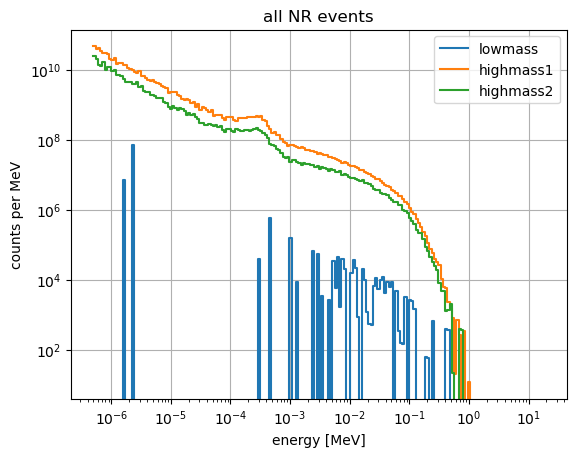

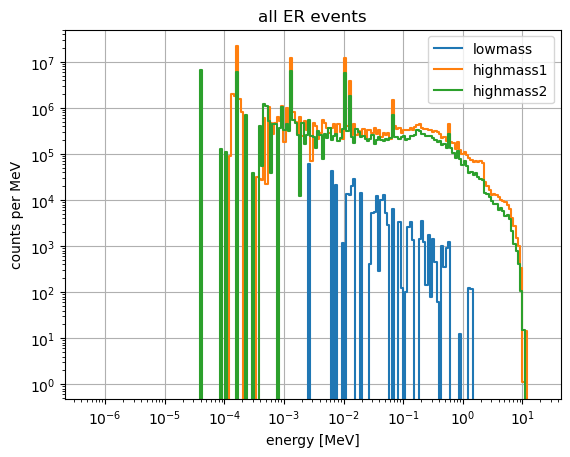

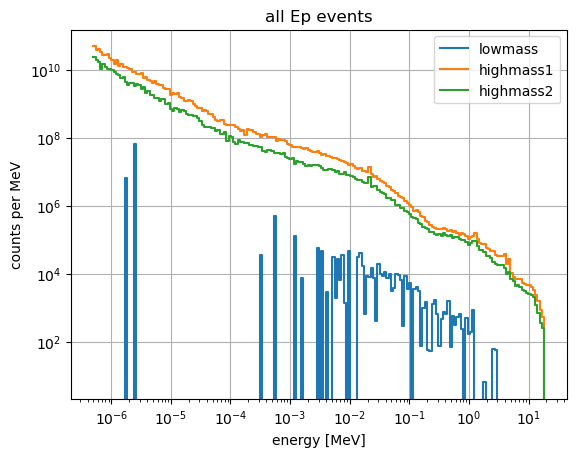

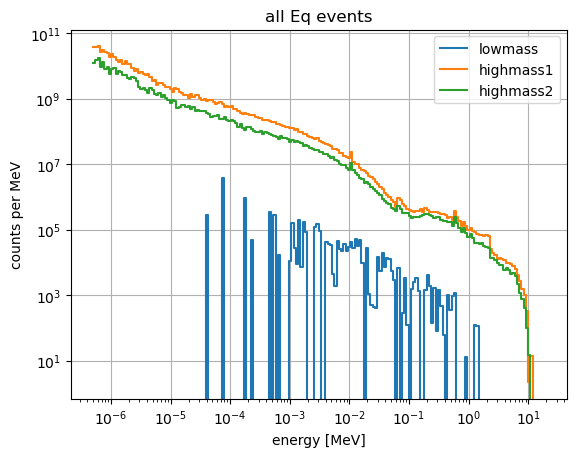

In [29]:
# all events

for Q in Qs:
    plt.figure()
    plt.grid()
    plt.loglog()
    plt.title(f'all {Q} events')
    plt.xlabel('energy [MeV]')
    plt.ylabel('counts per MeV')

    for det in detectors:
        hist = all_events[Q][det]
        plot_histo(hist, label = det)

    plt.legend()

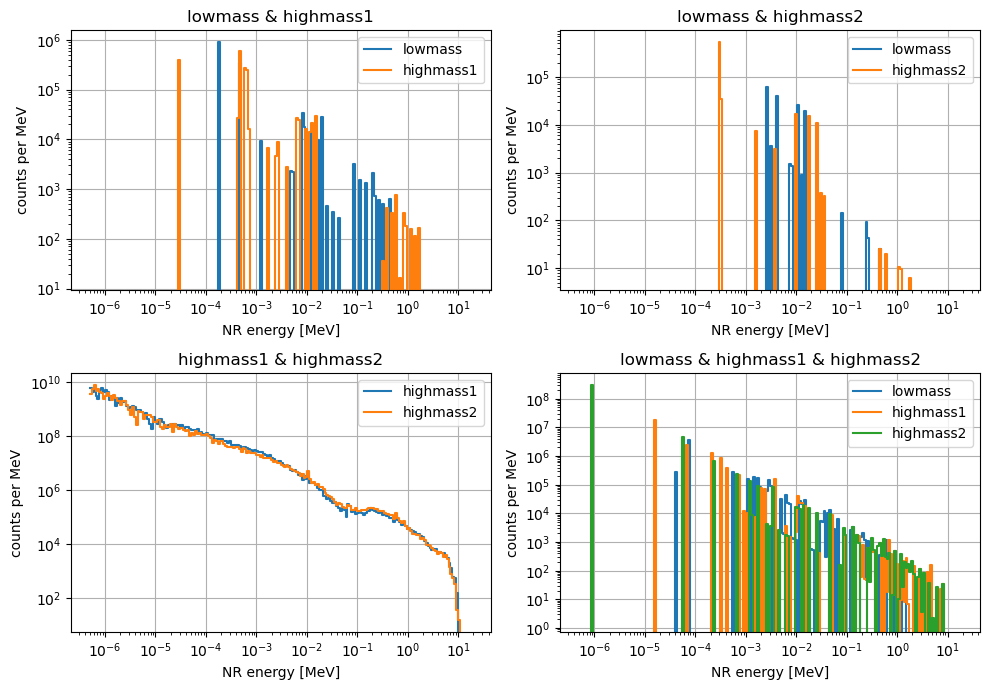

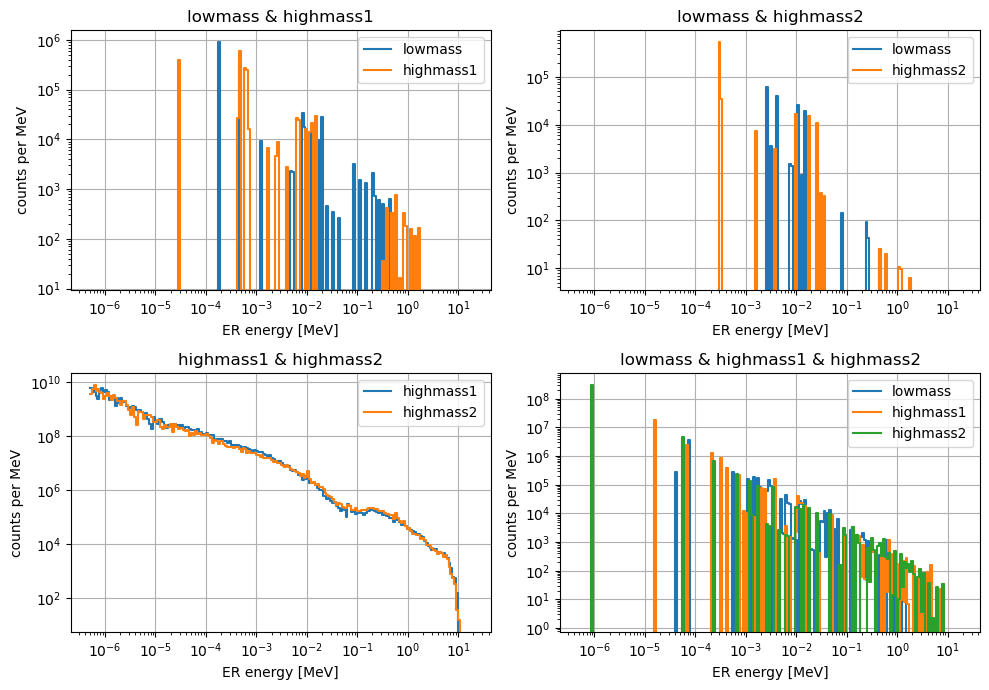

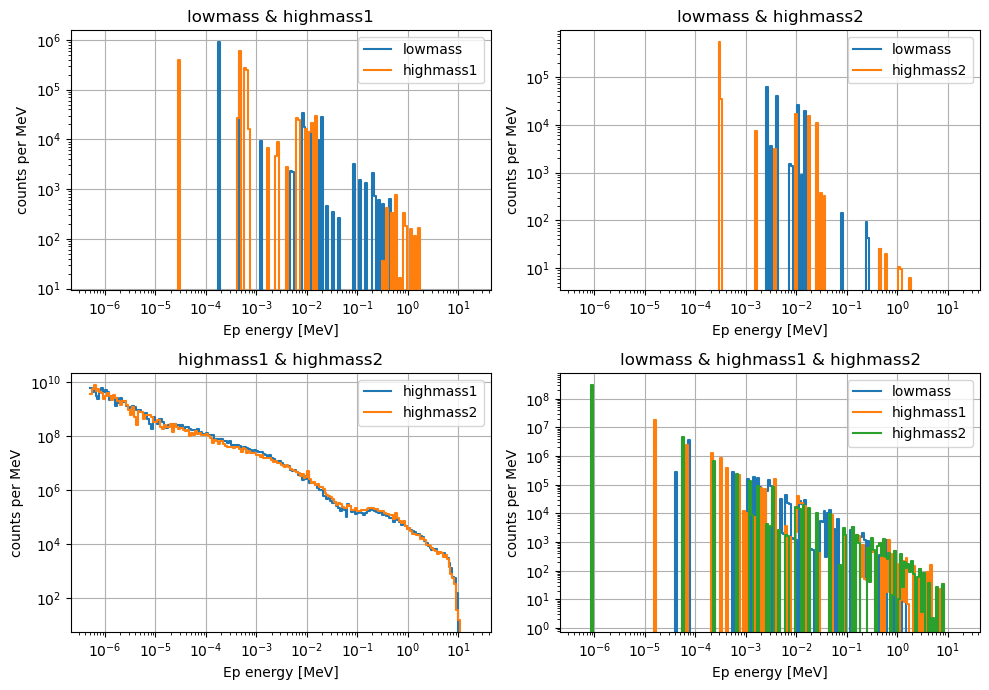

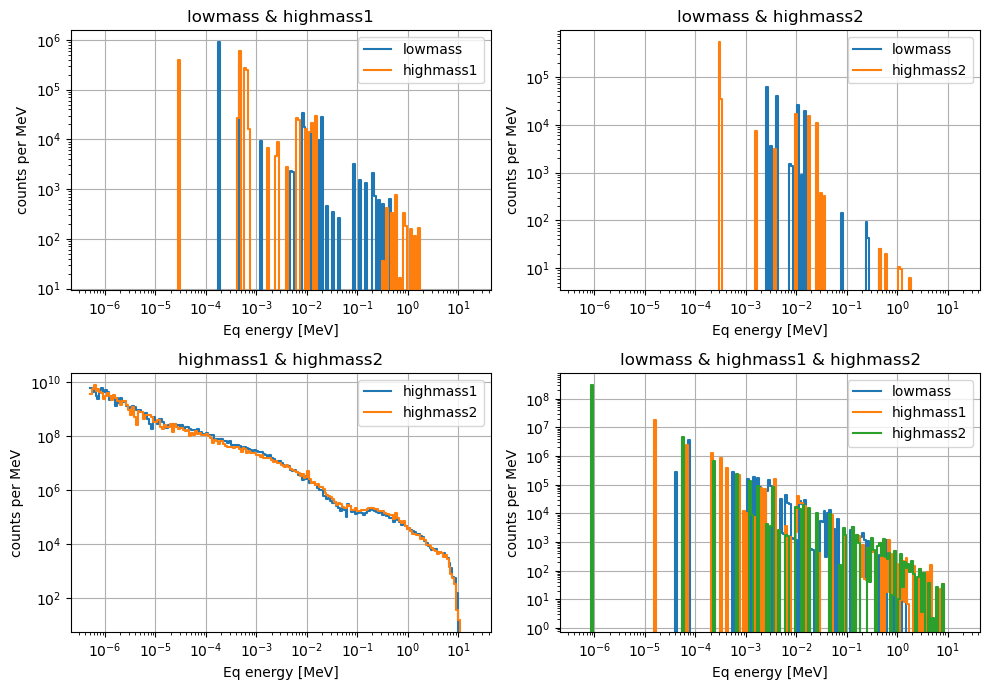

In [30]:
# coincidence events

for Q in Qs:

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7))

    for detdet, ax in zip(codetectors, axs.flatten()):
        ax.grid()
        ax.loglog()

        detdetstring = detdet.replace('x', ' & ')
        ax.set_title(f'{detdetstring}')
        
        ax.set_xlabel(f'{Q} energy [MeV]')
        ax.set_ylabel('counts per MeV')

        for det in detdet.split('x'):
            hist = coincidence_events[detdet][det][Q]
            plot_histo(hist, label = det, ax = ax)

        ax.legend()
    fig.tight_layout()

In [31]:
hist['count'].values.sum()

1008.0

In [32]:
Emin, Emax, Nbins

(5e-07, 18.33195580955897, 200)

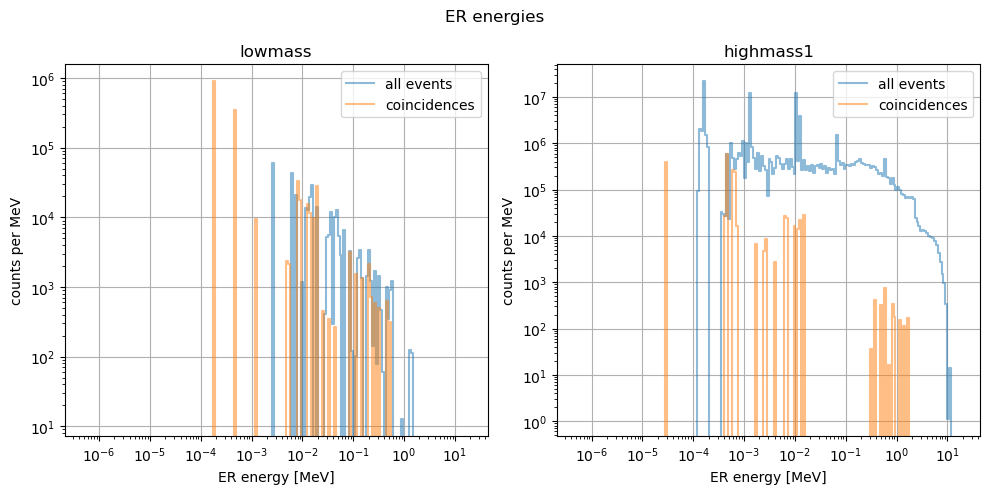

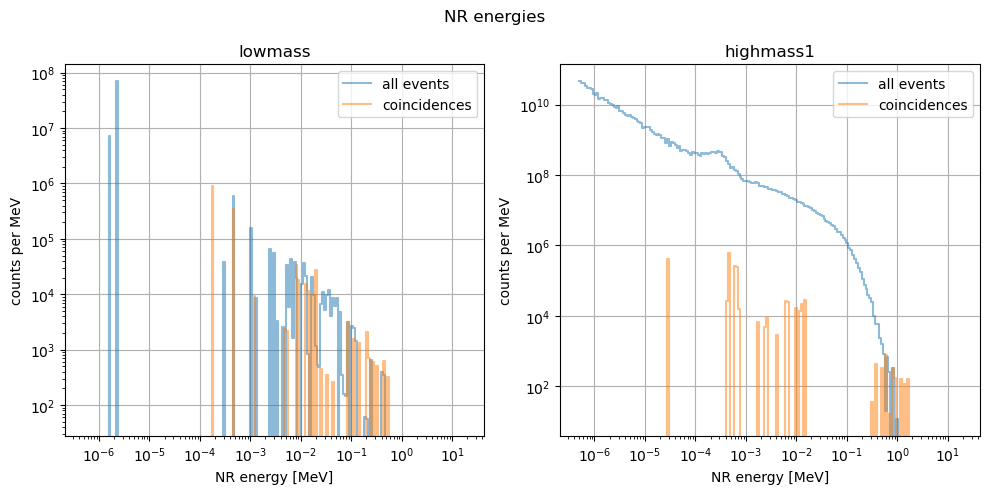

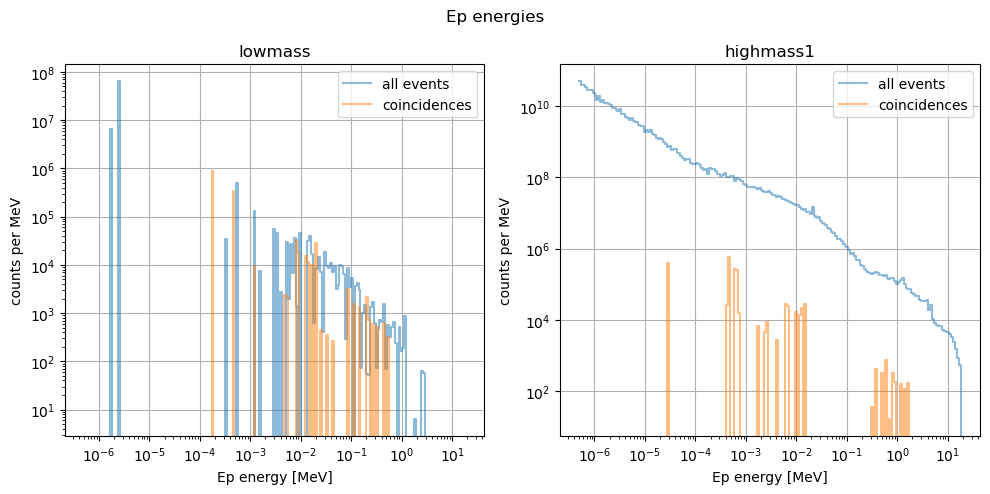

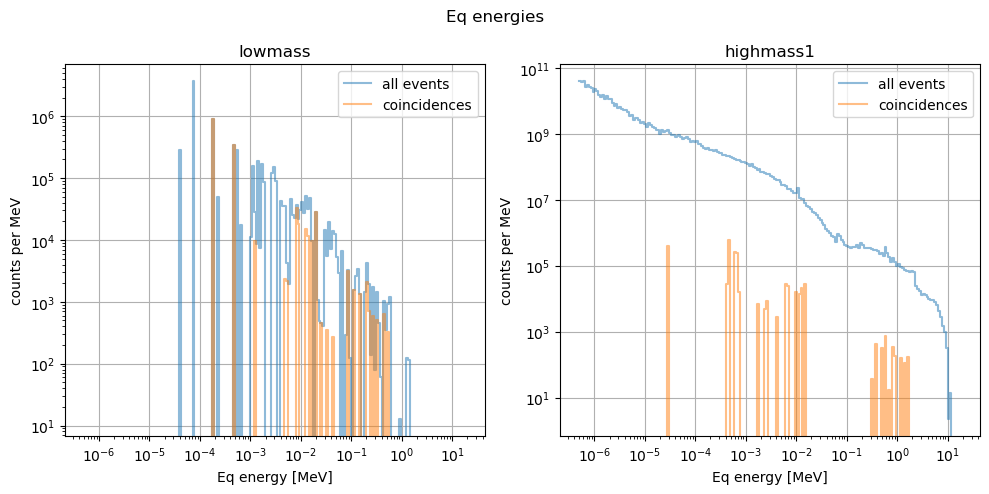

In [33]:
# lowmass/highmass1 spectra

d1 = 'lowmass'
d2 = 'highmass1'

for Q in ('ER', 'NR', 'Ep', 'Eq'):

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

    fig.suptitle(f'{Q} energies')

    for ax, det in zip(axs, (d1, d2)):

        ax.grid()
        ax.loglog()
        ax.set_title(det)
        ax.set_xlabel(f'{Q} energy [MeV]')
        ax.set_ylabel('counts per MeV')

        hists = (all_events[Q][det], coincidence_events[f'{d1}x{d2}'][det][Q])

        names = ('all events', 'coincidences')#, 'capture gammas')

        for hist, name in zip(hists, names):
            plot_histo(hist, ax = ax, label = name, alpha = 0.5)


        ax.legend()

    fig.tight_layout()


In [35]:
# print total rates
exposure_time = 270.27 # seconds

num_captures = {
    'lowmass': 0,
    'highmass1': 209009,
    'highmass2': 96165
}

evt_types = ('all events', 'coincidences', 'capture gammas')
codetectors = ['lowmassxhighmass1', 'lowmassxhighmass2', 'highmass1xhighmass2', 'lowmassxhighmass1xhighmass2']

dets = ('lowmass', 'highmass1', 'highmass2')
Qs = ['ER', 'NR', 'Ep']

def totals_string(ER, NR, Ep, cap):
    return f'{ER/exposure_time:.4g} ER, {NR/exposure_time:.4g} NR, {Ep/exposure_time:.4g} total, {cap/exposure_time:.4g} captures'


# all events:
# det vs Q+cap
totals_dict = {
    det: [
        get_histo(Q = Q, evt_type = 'all events', det = det)['count'].sum()/exposure_time
    for Q in Qs] + [num_captures[det]/exposure_time] for det in dets
}

df = pd.DataFrame.from_dict(totals_dict)
df.index = ['ER', 'NR', 'total', 'captures']

print(2*'\n')
print('event rates')
print(df.to_string())


# coinc:
# det/det rows, det column

coinc_dict = {
    det: [
        '--' if det not in detdet else get_histo(evt_type = 'coincidences', Q = 'Ep', det = det, detdet = detdet)['count'].sum()/exposure_time
    for detdet in codetectors] for det in dets
}
df = pd.DataFrame.from_dict(coinc_dict)
df.index = codetectors

print(2*'\n')
print('coincidences')
print(df.to_string())






event rates
           lowmass    highmass1    highmass2
ER        3.381803  1578.687979   977.648278
NR        2.534503  4222.943723  1929.603730
total     5.916306  4871.169571  2429.655530
captures  0.000000   773.334073   355.810856



coincidences
                              lowmass    highmass1   highmass2
lowmassxhighmass1            1.261701     1.261701          --
lowmassxhighmass2              0.3182           --      0.3182
highmass1xhighmass2                --  1184.940985  1190.23939
lowmassxhighmass1xhighmass2  3.677804     3.733304    3.729604
